# SONG POPULARITY DATA PREPARATION NOTEBOOK

## LOADING THE NECESSARY LIBRARIES

In [1]:
# !pip install catboost

In [2]:
#Import some libraries
import pandas as pd

pd.options.display.max_rows = 2200
pd.options.display.max_columns = 2200


import numpy as np
import gc
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from imblearn.over_sampling import SMOTE,RandomOverSampler
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier as cat
from collections import Counter
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,roc_auc_score,log_loss,precision_score
from sklearn.preprocessing import LabelEncoder,PolynomialFeatures,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,KNNImputer ,SimpleImputer

In [3]:
# #Start by connecting gdrive into the google colab
# from google.colab import drive
# drive.mount('/content/gdrive')
# path = "/content/gdrive/MyDrive/churn prediction"

LOAD THE DATASETS

In [4]:
#import data
# path+'/Train (10).csv'
train = pd.read_csv('train.csv')
test=  pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [5]:
train.head(2)

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1


In [6]:
train.shape

(40000, 15)

In [7]:
#view the data types in the data data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
id                  40000 non-null int64
song_duration_ms    35899 non-null float64
acousticness        36008 non-null float64
danceability        35974 non-null float64
energy              36025 non-null float64
instrumentalness    36015 non-null float64
key                 35935 non-null float64
liveness            35914 non-null float64
loudness            36043 non-null float64
audio_mode          40000 non-null int64
speechiness         40000 non-null float64
tempo               40000 non-null float64
time_signature      40000 non-null int64
audio_valence       40000 non-null float64
song_popularity     40000 non-null int64
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


In [8]:
duplicate = train[train.duplicated()]

In [9]:
duplicate.shape

(0, 15)

## EXPLORATORY DATA ANALYSIS

In [10]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

id                  40000
song_duration_ms    31587
acousticness        36005
danceability        35973
energy              36022
instrumentalness    36000
key                    13
liveness            35912
loudness            36039
audio_mode              2
speechiness         39999
tempo               39993
time_signature          4
audio_valence       39998
song_popularity         2
dtype: int64

0.0     5175
6.0     4949
10.0    4302
2.0     4080
8.0     3028
5.0     2985
9.0     2881
7.0     2690
4.0     2239
1.0     2143
3.0     1346
11.0     117
Name: key, dtype: int64


Text(0.5, 0, 'key')

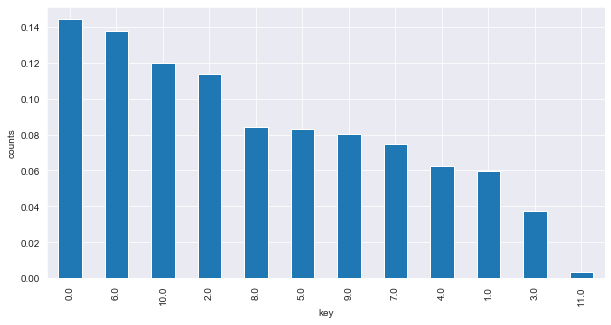

In [11]:
#Check how many levels are involved in each of the categorical features (object)
print(train['key'].value_counts())
plt.figure(figsize=(10,5))
train['key'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('key')

0    27154
1    12846
Name: audio_mode, dtype: int64


Text(0.5, 0, 'audio_mode')

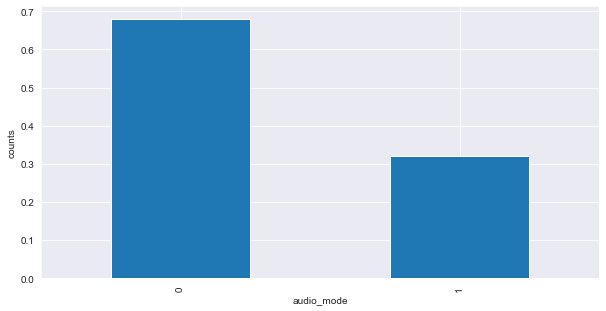

In [12]:
print(train['audio_mode'].value_counts())
plt.figure(figsize=(10,5))
train['audio_mode'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('audio_mode')

3    23358
4    15919
2      530
5      193
Name: time_signature, dtype: int64


Text(0.5, 0, 'time_signature')

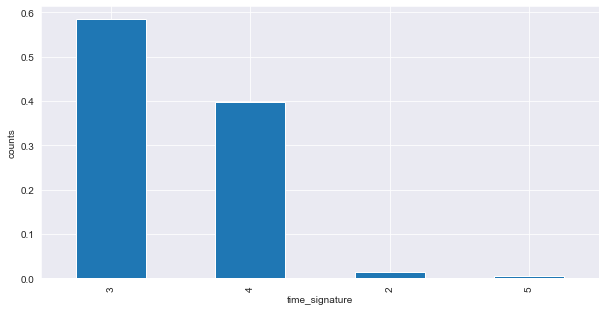

In [13]:
print(train['time_signature'].value_counts())
plt.figure(figsize=(10,5))
train['time_signature'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('time_signature')

0    25424
1    14576
Name: song_popularity, dtype: int64


Text(0.5, 0, 'song_popularity')

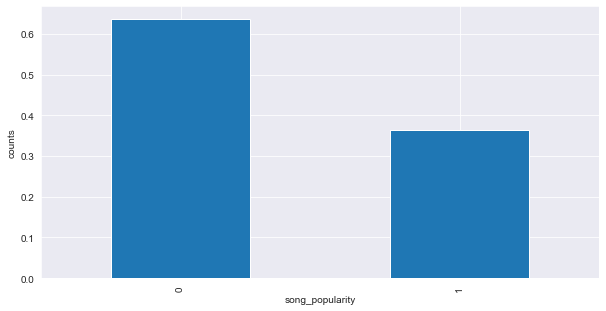

In [14]:
#Check if the predictor class is balanced 
print(train['song_popularity'].value_counts())
plt.figure(figsize=(10,5))
train['song_popularity'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('song_popularity')

Text(0.5, 1.0, 'time_signature VS song_popularity')

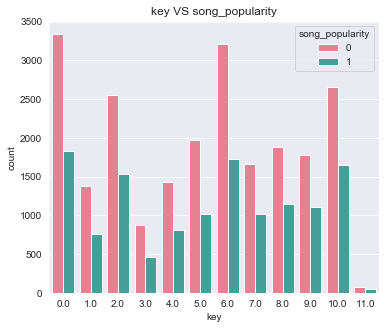

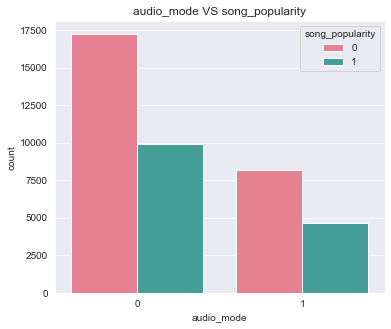

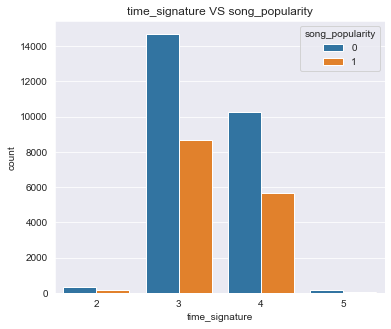

In [15]:
#NUMERICAL DATA THAT IS DISCRETE IN NATURE
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='key',hue='song_popularity',data=train,palette='husl')
plt.title("key VS song_popularity")


plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='audio_mode',hue='song_popularity',data=train,palette='husl')
plt.title("audio_mode VS song_popularity")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='time_signature',hue='song_popularity',data=train)
plt.title("time_signature VS song_popularity")


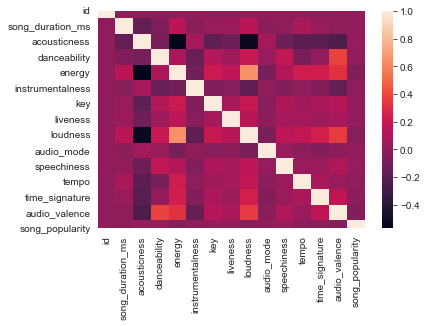

In [16]:
corr = train.corr()
sb.heatmap(corr)

In [17]:
#Check summary of numerical fields
train.select_dtypes(include=['int64', 'float64']).describe().T

,count,mean,std,min,25%,50%,75%,max
id,40000.0,19999.500000,11547.149720,0.000000,9999.750000,19999.500000,29999.250000,39999.000000
song_duration_ms,35899.0,193165.847572,45822.127679,25658.000000,166254.500000,186660.000000,215116.000000,491671.000000
acousticness,36008.0,0.276404,0.297928,-0.013551,0.039618,0.140532,0.482499,1.065284
danceability,35974.0,0.570951,0.190010,0.043961,0.424760,0.608234,0.718464,0.957131
energy,36025.0,0.683932,0.212662,-0.001682,0.539276,0.704453,0.870503,1.039741
instrumentalness,36015.0,0.036527,0.150024,-0.004398,0.000941,0.001974,0.003225,1.075415
key,35935.0,5.042605,3.372728,0.000000,2.000000,5.000000,8.000000,11.000000
liveness,35914.0,0.198514,0.151670,0.027843,0.111796,0.135945,0.212842,1.065298
loudness,36043.0,-7.407596,3.877198,-32.117911,-9.578139,-6.345413,-4.620711,-0.877346
audio_mode,40000.0,0.321150,0.466924,0.000000,0.000000,0.000000,1.000000,1.000000


In [18]:
# #id is not an important feature so we drop it
# train.drop(['id'], 1, inplace = True)
# test.drop([ 'id'], 1, inplace = True)

## DATA MANIPULATION

In [19]:
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

In [20]:
#check for missing values
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_data = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_data

,column_name,percent_missing
acousticness,acousticness,9.884
audio_mode,audio_mode,0.000
audio_valence,audio_valence,0.000
danceability,danceability,10.004
energy,energy,10.060
id,id,0.000
instrumentalness,instrumentalness,9.970
key,key,10.114
liveness,liveness,10.184
loudness,loudness,9.966


## HANDLING MISSING DATA

In real world data if you use sklearn impute methods you have to fit and transform the train data first then transform the test data separately because the test is unseen data, but in a compettion environment you can cheat by fit_transforming the whole data concatenated since you already are provided with the test data.

In [21]:
#Key was a discrete numerical column so i filled it with 0.0 since it was the  most frequent
data['key'] = data['key'].fillna(0.0)

ITERATIVE IMPUTER

In [22]:
#i used iterative imputer for the continuous numerical columns
X1 = data[['song_duration_ms','liveness',  'danceability',  'instrumentalness','energy' ,'acousticness' ,'loudness']] 
# X2 = data[[ 'key']]

iter_im  = IterativeImputer(random_state =47 ,max_iter = 60)
X1_out = iter_im.fit_transform(X1)



In [23]:
data[['song_duration_ms','liveness',  'danceability',  'instrumentalness','energy' ,'acousticness' ,'loudness']] = X1_out
# data[[ 'key']] = X2_out
data.head()


,acousticness,audio_mode,audio_valence,danceability,energy,id,instrumentalness,key,liveness,loudness,song_duration_ms,song_popularity,speechiness,tempo,time_signature
0,0.642286,0,0.734642,0.856520,0.707073,0,0.002001,10.0,0.202961,-5.619088,212990.000000,0.0,0.082570,158.386236,4
1,0.054866,1,0.711531,0.733289,0.835545,1,0.000996,8.0,0.436428,-5.236965,196927.675845,1.0,0.127358,102.752988,3
2,0.177167,0,0.425536,0.188387,0.783524,2,-0.002694,5.0,0.170499,-4.951759,193213.000000,0.0,0.052282,178.685791,3
3,0.488660,0,0.453597,0.585234,0.552685,3,0.000608,0.0,0.094805,-7.893694,249893.000000,0.0,0.035618,128.715630,3
4,0.493017,0,0.741311,0.635743,0.740982,4,0.002033,10.0,0.094891,-2.684095,165969.000000,0.0,0.050746,121.928157,4


KNN IMPUTER

In [24]:
#Wanted to use KNN imputer for categorical missing features but it takes a lot of time in my local machine which has a slow processor


# knn_im = KNNImputer(n_neighbors=5, weights='uniform')
# X2_out = knn_im.fit_transform(X2)

In [25]:
data.columns

Index(['acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'song_duration_ms', 'song_popularity', 'speechiness', 'tempo',
       'time_signature'],
      dtype='object')

## FEATURE ENGINEERING

MEAN ENCODING

In [26]:

KEY = data.groupby('key').mean()
KEY.drop(['song_popularity'], 1, inplace = True)
cols = []
for i in KEY.columns:
    if i != 'key':
        KEY[i+'_key_mean_all'] = KEY[i]
        KEY.drop(i, 1, inplace = True)
        cols.append(i+'_key_mean_all')

data = pd.merge(data, KEY, on='key', how = 'left')



In [27]:
AUDIOMODE = data.groupby('audio_mode').mean()
AUDIOMODE.drop(['song_popularity','acousticness_key_mean_all', 'audio_valence_key_mean_all',
       'danceability_key_mean_all', 'energy_key_mean_all',
       'instrumentalness_key_mean_all', 'liveness_key_mean_all',
       'loudness_key_mean_all', 'song_duration_ms_key_mean_all',
       'speechiness_key_mean_all', 'tempo_key_mean_all','audio_mode_key_mean_all','time_signature_key_mean_all'], 1, inplace = True)
cols = []
for i in AUDIOMODE.columns:
    if i != 'audio_mode':
        AUDIOMODE[i+'_audio_mode_mean_all'] = AUDIOMODE[i]
        AUDIOMODE.drop(i, 1, inplace = True)
        cols.append(i+'_audio_mode_mean_all')

data = pd.merge(data, AUDIOMODE, on='audio_mode', how = 'left')

In [28]:
TIME_SIGNATURE = data.groupby('time_signature').mean()
TIME_SIGNATURE.drop(['song_popularity','acousticness_key_mean_all', 'audio_valence_key_mean_all',
       'danceability_key_mean_all', 'energy_key_mean_all',
       'instrumentalness_key_mean_all', 'liveness_key_mean_all',
       'loudness_key_mean_all', 'song_duration_ms_key_mean_all',
       'speechiness_key_mean_all', 'tempo_key_mean_all','audio_mode_key_mean_all','time_signature_key_mean_all',
       'acousticness_audio_mode_mean_all', 'audio_valence_audio_mode_mean_all',
       'danceability_audio_mode_mean_all', 'energy_audio_mode_mean_all',
       'instrumentalness_audio_mode_mean_all', 'liveness_audio_mode_mean_all',
       'loudness_audio_mode_mean_all', 'song_duration_ms_audio_mode_mean_all',
       'speechiness_audio_mode_mean_all', 'tempo_audio_mode_mean_all','key_audio_mode_mean_all','time_signature_audio_mode_mean_all'], 1, inplace = True)
cols = []
for i in TIME_SIGNATURE.columns:
    if i != 'time_signature':
        TIME_SIGNATURE[i+'_time_signature_mean_all'] = TIME_SIGNATURE[i]
        TIME_SIGNATURE.drop(i, 1, inplace = True)
        cols.append(i+'_time_signature_mean_all')

data = pd.merge(data, TIME_SIGNATURE, on='time_signature', how = 'left')

FEATAURE INTERACTIONS

In [29]:
data['acousticness_key_mean_all_diff'] = data['acousticness'] - data['acousticness_key_mean_all']
data['acousticness_audio_mode_mean_all_diff'] = data['acousticness'] - data['acousticness_audio_mode_mean_all']
data['acousticness_time_signature_mean_all_diff'] = data['acousticness'] - data['acousticness_time_signature_mean_all']

data['audio_valence_key_mean_all_diff'] = data['audio_valence'] - data['audio_valence_key_mean_all']
data['audio_valence_audio_mode_mean_all_diff'] = data['audio_valence'] - data['audio_valence_audio_mode_mean_all']
data['audio_valence_time_signature_mean_all_diff'] = data['audio_valence'] - data['audio_valence_time_signature_mean_all']

data['danceability_key_mean_all_diff'] = data['danceability'] - data['danceability_key_mean_all']
data['danceability_audio_mode_mean_all_diff'] = data['danceability'] - data['danceability_audio_mode_mean_all']
data['danceability_time_signature_mean_all_diff'] = data['danceability'] - data['danceability_time_signature_mean_all']

data['energy_key_mean_all_diff'] = data['energy'] - data['energy_key_mean_all']
data['energy_audio_mode_mean_all_diff'] = data['energy'] - data['energy_audio_mode_mean_all']
data['energy_time_signature_mean_all_diff'] = data['energy'] - data['energy_time_signature_mean_all']

data['instrumentalness_key_mean_all_diff'] = data['instrumentalness'] - data['instrumentalness_key_mean_all']
data['instrumentalness_audio_mode_mean_all_diff'] = data['instrumentalness'] - data['instrumentalness_audio_mode_mean_all']
data['instrumentalness_time_signature_mean_all_diff'] = data['instrumentalness'] - data['instrumentalness_time_signature_mean_all']

data['liveness_key_mean_all_diff'] = data['liveness'] - data['liveness_key_mean_all']
data['liveness_audio_mode_mean_all_diff'] = data['liveness'] - data['liveness_audio_mode_mean_all']
data['liveness_time_signature_mean_all_diff'] = data['liveness'] - data['liveness_time_signature_mean_all']

data['loudness_key_mean_all_diff'] = data['loudness'] - data['loudness_key_mean_all']
data['loudness_audio_mode_mean_all_diff'] = data['loudness'] - data['loudness_audio_mode_mean_all']
data['loudness_time_signature_mean_all_diff'] = data['loudness'] - data['loudness_time_signature_mean_all']

data['song_duration_ms_key_mean_all_diff'] = data['song_duration_ms'] - data['song_duration_ms_key_mean_all']
data['song_duration_ms_audio_mode_mean_all_diff'] = data['song_duration_ms'] - data['song_duration_ms_audio_mode_mean_all']
data['song_duration_ms_time_signature_mean_all_diff'] = data['song_duration_ms'] - data['song_duration_ms_time_signature_mean_all']

data['speechiness_key_mean_all_diff'] = data['speechiness'] - data['speechiness_key_mean_all']
data['speechiness_audio_mode_mean_all_diff'] = data['speechiness'] - data['speechiness_audio_mode_mean_all']
data['speechiness_time_signature_mean_all_diff'] = data['speechiness'] - data['speechiness_time_signature_mean_all']

data['tempo_key_mean_all_diff'] = data['tempo'] - data['tempo_key_mean_all']
data['tempo_audio_mode_mean_all_diff'] = data['tempo'] - data['tempo_audio_mode_mean_all']
data['tempo_time_signature_mean_all_diff'] = data['tempo'] - data['tempo_time_signature_mean_all']



In [30]:
data['energy_loudness_sum'] = data['energy'] + data['loudness']
data['energy_loudness_diff'] = data['energy'] - data['loudness']

data['audvalence_danceability_diff'] = data['audio_valence'] - data['danceability']
data['audvalence_danceability_sum'] = data['audio_valence'] + data['danceability']

data['audvalence_loudness_sum'] = data['audio_valence'] + data['loudness']
data['audvalence_loudness_diff'] = data['audio_valence'] - data['loudness']

data['audvalence_loudness_diff'] = data['audio_valence'] - data['energy']
data['audvalence_loudness_sum'] = data['audio_valence'] + data['energy']

data['danceability_valence'] = data['danceability']+data['audio_valence']
data['danceability_valence_diff'] = data['danceability'] - data['audio_valence']


data['tempo_danceability'] = data['tempo'] + data['danceability']
data['tempo_danceability_diff'] = data['tempo'] - data['danceability']

data['speechiness_valence'] = data['speechiness'] + data['audio_valence']
data['speechiness_valence_diff'] = data['speechiness'] - data['audio_valence']

data['loudness_speechiness_diff'] = data['loudness'] - data['speechiness']
data['loudness_speechiness'] = data['loudness'] + data['speechiness']

data['audio_valence_speechiness'] = data['audio_valence'] + data['speechiness']
data['audio_valence_speechiness_diff'] = data['audio_valence'] - data['speechiness']



data['energy_acousticness_diff'] = data['energy'] - data['acousticness']
data['energy_acousticness'] = data['energy'] + data['acousticness']

data['loudness_acousticness_diff'] = data['loudness'] - data['acousticness']
data['loudness_acousticness'] = data['loudness'] + data['acousticness']

data['energy_danceability'] = data['energy']+ data['danceability']
data['energy_danceability_diff'] = data['energy'] - data['danceability']

data['instrumentalness_acousticness_diff'] = data['instrumentalness'] - data['acousticness']
data['instrumentalness_acousticness'] = data['instrumentalness'] + data['acousticness']



data['time_danceability'] = data['time_signature'] * data['danceability']
data['time_danceability_div'] = data['danceability'] / data['time_signature']

data['time_energy'] = data['time_signature'] * data['energy']
data['time_energy_div'] = data['energy'] / data['time_signature']

data['time_loudness'] = data['time_signature']* data['loudness']
data['time_loudness_div'] = data['loudness'] / data['time_signature'] 

data['key_instrumentalness '] = data['key'] * data['instrumentalness']


data['time_tempo'] = data['time_signature'] * data['tempo']
data['time_tempo_div'] = data['tempo'] / data['time_signature']

data['key_acousticness '] = data['key'] * data['acousticness']

data['superior_features'] = data['audio_valence'] + data['danceability'] + data['energy']
data['inferior_features'] = data['liveness'] + data['speechiness'] + data['acousticness']

data['time_signature_accousticness'] = data['time_signature'] + data['acousticness']
data['time_signature_accousticness_div'] =  data['acousticness']/data['time_signature']

data['danceability_instrumentalness'] = data['danceability'] + data['instrumentalness']
data['danceability_instrumentalness_diff'] = data['danceability'] - data['instrumentalness']

data['energy_audio_valence'] = data['energy'] + data['audio_valence']
data['energy_audio_valence_diff'] = data['energy'] - data['audio_valence']

data['energy_time_signature'] = data['energy'] + data['time_signature']

data['energy_liveness'] = data['energy'] + data['liveness']
data['energy_liveness_diff'] = data['energy'] - data['liveness']

data['energy_instrumentalness'] = data['energy'] + data['instrumentalness']
data['energy_instrumentalness_diff'] = data['energy'] - data['instrumentalness']
 
data['instrumentalness_audio_valence'] = data['instrumentalness'] + data['audio_valence']
data['instrumentalness_audio_valence_diff'] = data['instrumentalness'] - data['audio_valence']
       

GETTING TIME FEATURES FROM SONG_DURATION_MS FEATURE

In [31]:
def add_standard_time(data): 
    ms = data['song_duration_ms']
    millis = ms
    seconds=(millis/1000)%60
    minutes=(millis/(1000*60))%60
    hours=(millis/(1000*60*60))%24
    data['song_duration_s'] = seconds
    data['song_duration_m'] = minutes
    data['song_duration_h'] = hours
    return data

data = add_standard_time(data)


In [32]:
data.head()

,acousticness,audio_mode,audio_valence,danceability,energy,id,instrumentalness,key,liveness,loudness,song_duration_ms,song_popularity,speechiness,tempo,time_signature,acousticness_key_mean_all,audio_mode_key_mean_all,audio_valence_key_mean_all,danceability_key_mean_all,energy_key_mean_all,id_key_mean_all,instrumentalness_key_mean_all,liveness_key_mean_all,loudness_key_mean_all,song_duration_ms_key_mean_all,speechiness_key_mean_all,tempo_key_mean_all,time_signature_key_mean_all,acousticness_audio_mode_mean_all,audio_valence_audio_mode_mean_all,danceability_audio_mode_mean_all,energy_audio_mode_mean_all,id_audio_mode_mean_all,instrumentalness_audio_mode_mean_all,key_audio_mode_mean_all,liveness_audio_mode_mean_all,loudness_audio_mode_mean_all,song_duration_ms_audio_mode_mean_all,speechiness_audio_mode_mean_all,tempo_audio_mode_mean_all,time_signature_audio_mode_mean_all,id_key_mean_all_audio_mode_mean_all,acousticness_time_signature_mean_all,audio_mode_time_signature_mean_all,audio_valence_time_signature_mean_all,danceability_time_signature_mean_all,energy_time_signature_mean_all,id_time_signature_mean_all,instrumentalness_time_signature_mean_all,key_time_signature_mean_all,liveness_time_signature_mean_all,loudness_time_signature_mean_all,song_duration_ms_time_signature_mean_all,speechiness_time_signature_mean_all,tempo_time_signature_mean_all,id_key_mean_all_time_signature_mean_all,id_audio_mode_mean_all_time_signature_mean_all,id_key_mean_all_audio_mode_mean_all_time_signature_mean_all,acousticness_key_mean_all_diff,acousticness_audio_mode_mean_all_diff,acousticness_time_signature_mean_all_diff,audio_valence_key_mean_all_diff,audio_valence_audio_mode_mean_all_diff,audio_valence_time_signature_mean_all_diff,danceability_key_mean_all_diff,danceability_audio_mode_mean_all_diff,danceability_time_signature_mean_all_diff,energy_key_mean_all_diff,energy_audio_mode_mean_all_diff,energy_time_signature_mean_all_diff,instrumentalness_key_mean_all_diff,instrumentalness_audio_mode_mean_all_diff,instrumentalness_time_signature_mean_all_diff,liveness_key_mean_all_diff,liveness_audio_mode_mean_all_diff,liveness_time_signature_mean_all_diff,loudness_key_mean_all_diff,loudness_audio_mode_mean_all_diff,loudness_time_signature_mean_all_diff,song_duration_ms_key_mean_all_diff,song_duration_ms_audio_mode_mean_all_diff,song_duration_ms_time_signature_mean_all_diff,speechiness_key_mean_all_diff,speechiness_audio_mode_mean_all_diff,speechiness_time_signature_mean_all_diff,tempo_key_mean_all_diff,tempo_audio_mode_mean_all_diff,tempo_time_signature_mean_all_diff,energy_loudness_sum,energy_loudness_diff,audvalence_danceability_diff,audvalence_danceability_sum,audvalence_loudness_sum,audvalence_loudness_diff,danceability_valence,danceability_valence_diff,tempo_danceability,tempo_danceability_diff,speechiness_valence,speechiness_valence_diff,loudness_speechiness_diff,loudness_speechiness,audio_valence_speechiness,audio_valence_speechiness_diff,energy_acousticness_diff,energy_acousticness,loudness_acousticness_diff,loudness_acousticness,energy_danceability,energy_danceability_diff,instrumentalness_acousticness_diff,instrumentalness_acousticness,time_danceability,time_danceability_div,time_energy,time_energy_div,time_loudness,time_loudness_div,key_instrumentalness,time_tempo,time_tempo_div,key_acousticness,superior_features,inferior_features,time_signature_accousticness,time_signature_accousticness_div,danceability_instrumentalness,danceability_instrumentalness_diff,energy_audio_valence,energy_audio_valence_diff,energy_time_signature,energy_liveness,energy_liveness_diff,energy_instrumentalness,energy_instrumentalness_diff,instrumentalness_audio_valence,instrumentalness_audio_valence_diff,song_duration_s,song_duration_m,song_duration_h
0,0.642286,0,0.734642,0.856520,0.707073,0,0.002001,10.0,0.202961,-5.619088,212990.000000,0.0,0.082570,158.386236,4,0.286199,0.352919,0.603265,0.624460,0.649781,17115.551017,0.031458,0.201431,-7.718314,192385.244335,0.114001,114

BINNING

In [33]:
# data['accousticness_bins'] = data['acousticness'].apply(lambda x:1 if x > 0.5 else 0)
# data['danceability_bins'] = data['danceability'].apply(lambda x:1 if x > 0.5 else 0)
# data['energy_bins'] = data['energy'].apply(lambda x:1 if x>0.5 else 0)
# data['instrumentalness_bins'] = data['instrumentalness'].apply(lambda x:1 if x>0.09 else 0)
# data['liveness_bins'] = data['liveness'].apply(lambda x:1 if x>0.2 else 0)
# data['loudness_bins']= data['loudness'].apply(lambda x:1 if x > -13 else 0)
# data['speechiness_bins']= data['speechiness'].apply(lambda x:1 if x>0.25 else 0)

POLYNOMIAL FEATURES

In [34]:
# poly_cols = ['acousticness','audio_valence', 'danceability', 'energy','instrumentalness','liveness', 'loudness',
#        'song_duration_ms','speechiness', 'tempo']
# poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
# data_poly = poly.fit_transform(data[poly_cols])
# df_poly = pd.DataFrame(data_poly, columns=[f"poly_{i}" for i in range(data_poly.shape[1])])
# data = pd.concat([data, df_poly], axis=1)

In [35]:
data.columns

Index(['acousticness', 'audio_mode', 'audio_valence', 'danceability', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       ...
       'energy_time_signature', 'energy_liveness', 'energy_liveness_diff',
       'energy_instrumentalness', 'energy_instrumentalness_diff',
       'instrumentalness_audio_valence', 'instrumentalness_audio_valence_diff',
       'song_duration_s', 'song_duration_m', 'song_duration_h'],
      dtype='object', length=140)

## HANDLING OUTLIERS

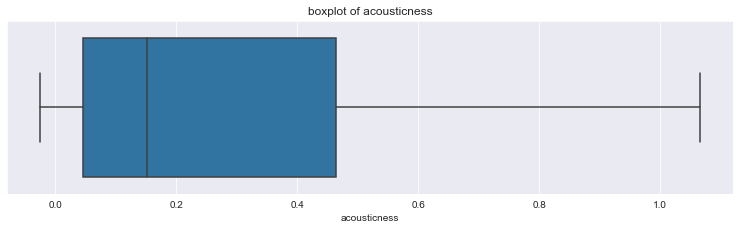

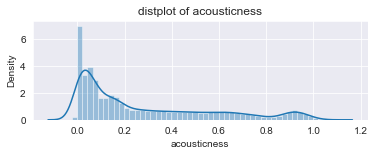

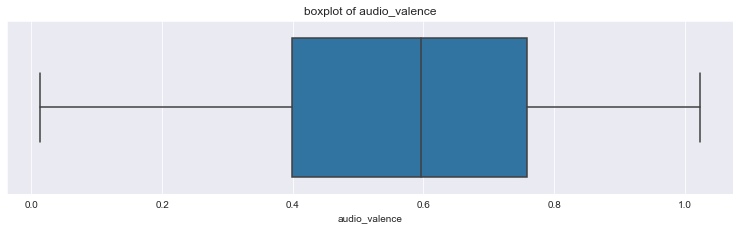

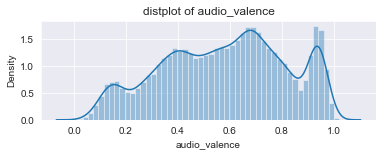

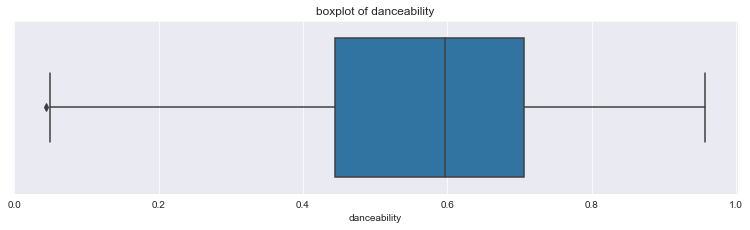

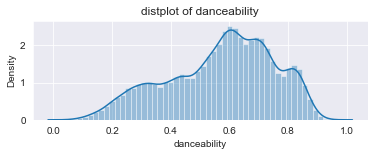

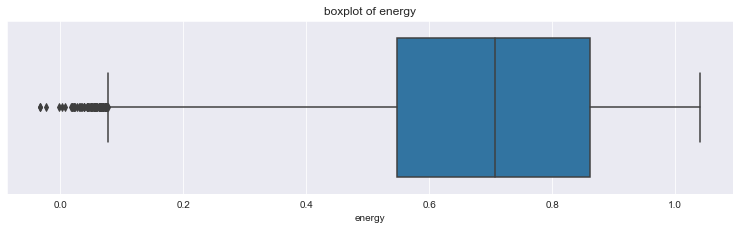

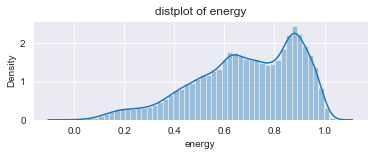

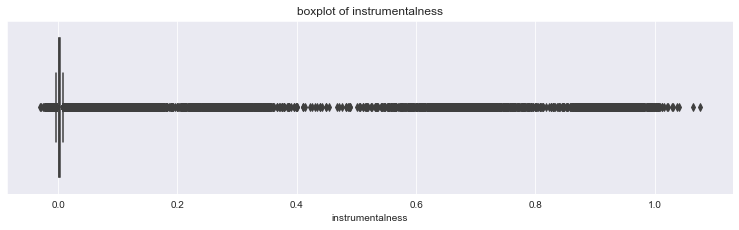

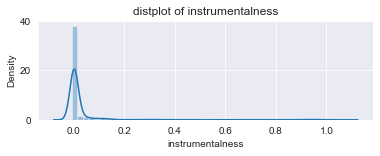

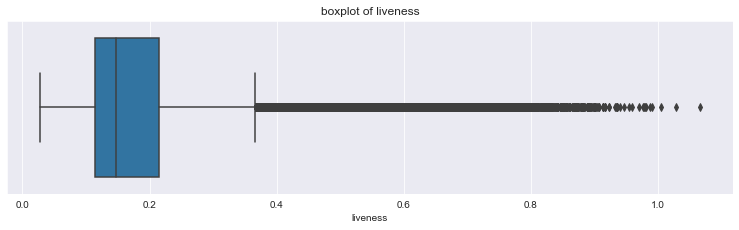

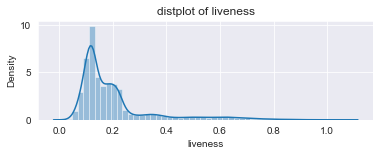

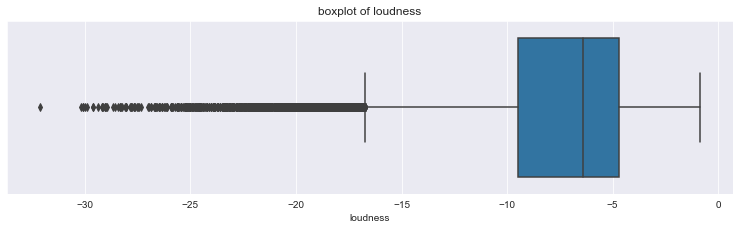

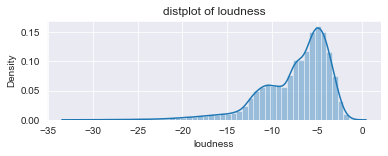

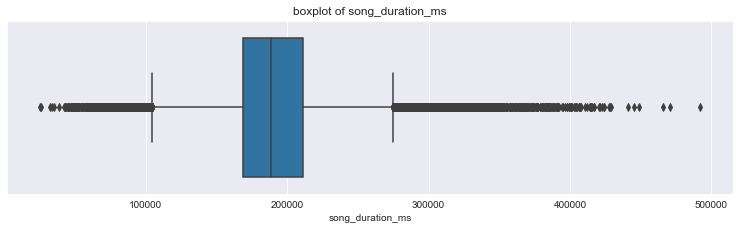

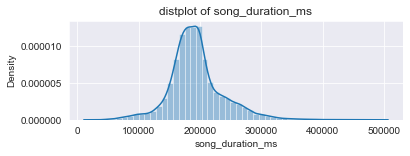

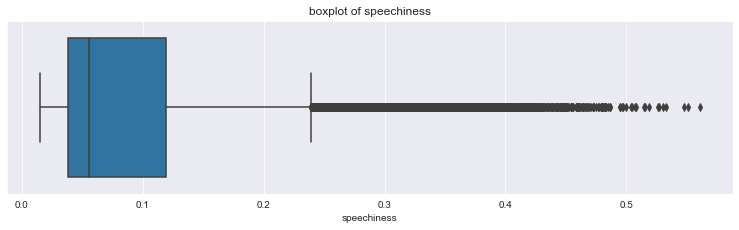

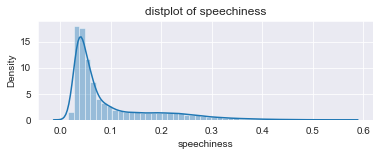

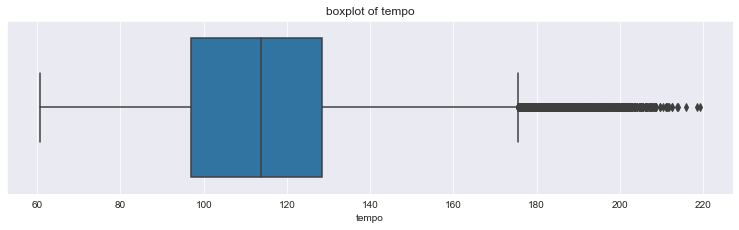

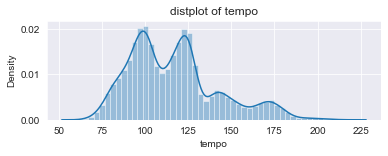

In [36]:
#finding outliers and skewness
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['acousticness'])
plt.title("boxplot of acousticness")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["acousticness"])
plt.title("distplot of acousticness")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['audio_valence'])
plt.title("boxplot of audio_valence")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["audio_valence"])
plt.title("distplot of audio_valence")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['danceability'])
plt.title("boxplot of danceability")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["danceability"])
plt.title("distplot of danceability")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['energy'])
plt.title("boxplot of energy")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["energy"])
plt.title("distplot of energy")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['instrumentalness'])
plt.title("boxplot of instrumentalness")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["instrumentalness"])
plt.title("distplot of instrumentalness")
plt.show()

plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['liveness'])
plt.title("boxplot of liveness")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["liveness"])
plt.title("distplot of liveness")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['loudness'])
plt.title("boxplot of loudness")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["loudness"])
plt.title("distplot of loudness")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['song_duration_ms'])
plt.title("boxplot of song_duration_ms")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["song_duration_ms"])
plt.title("distplot of song_duration_ms")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['speechiness'])
plt.title("boxplot of speechiness")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["speechiness"])
plt.title("distplot of speechiness")
plt.show()
plt.figure(figsize=(13,7))
plt.subplot(2,1,2)
sb.boxplot(data['tempo'])
plt.title("boxplot of tempo")
plt.show()
plt.subplot(2,1,2)
sb.distplot(data["tempo"])
plt.title("distplot of tempo")
plt.show()

In [37]:
data[['liveness','acousticness','loudness','speechiness','tempo']].describe()

,liveness,acousticness,loudness,speechiness,tempo
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.198067,0.276779,-7.409140,0.094134,116.542379
std,0.143552,0.288927,3.781181,0.083731,26.198184
min,0.027843,-0.024826,-32.117911,0.015065,60.702888
25%,0.114183,0.046419,-9.499886,0.038476,96.987758
50%,0.147504,0.152388,-6.418930,0.055733,113.720325
75%,0.215112,0.463938,-4.684650,0.118862,128.416644
max,1.065298,1.065284,-0.877346,0.560748,219.163578


In [38]:
#Instead of dropping the outliers i decided to cap them with the 0.05 and 0.95 percentiles 

data['acousticness'].loc[data['acousticness'] > 1.017023]  = 1.017023
data['audio_valence'].loc[data['audio_valence'] < 0.048032]  = 0.048032
data['danceability'].loc[data['danceability'] < 0.094157]  = 0.094157
data['energy'].loc[data['energy'] < 0.094157]  = 0.094157
data['liveness'].loc[data['liveness'] > 0.891825]  = 0.891825
data['loudness'].loc[data['loudness'] < -26.502428]  = -26.502428
data['song_duration_ms'].loc[data['song_duration_ms'] > 390929.37000]  = 390929.37000
data['song_duration_ms'].loc[data['song_duration_ms'] < 54007.36300]  = 54007.36300
data['speechiness'].loc[data['speechiness'] > 0.465412]  = 0.465412
data['tempo'].loc[data['tempo'] > 204.984966]  = 204.984966
data['instrumentalness'].loc[data['instrumentalness'] > 0.987538]  = 0.987538
data['instrumentalness'].loc[data['instrumentalness'] < -0.004398]  = -0.004398


#Some Transformations to deal with the skewness of some features 
data['instrumentalness'] = np.log(1+data['instrumentalness'])
data['log_norm_EL'] = data['energy']+ np.exp(data['loudness'])*100
data['deNorm_acoust'] = data['acousticness']*data['log_norm_EL']
data['liveness_log'] = np.log(data['liveness'])
data['accousticness_sqrt'] = np.sqrt(data['acousticness'])
data['loudness_abs'] = abs(data['loudness'])
data['loudness_log'] = np.log(data['loudness_abs'])
data['speechiness_log'] = np.log(data['speechiness'])
data['tempo_log'] = np.log(data['tempo'])


In [39]:
# df['loudness'] = abs(df['loudness'])
# transformation(df, 'liveness', 'log')
# transformation(df, 'acousticness', 'sqrt')
# transformation(df, 'loudness', 'log')
# transformation(df, 'speechiness', 'log')
# transformation(df, 'tempo', 'log')

# df.drop('instrumentalness', axis=1, inplace=True)


In [40]:
data.isnull().sum()

acousticness                                                       0
audio_mode                                                         0
audio_valence                                                      0
danceability                                                       0
energy                                                             0
id                                                                 0
instrumentalness                                                   0
key                                                                0
liveness                                                           0
loudness                                                           0
song_duration_ms                                                   0
song_popularity                                                10000
speechiness                                                        0
tempo                                                              0
time_signature                    

## LABEL ENCODING

In [41]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# data["key"] = le.fit_transform(data["key"])
# data["time_signature"] = le.fit_transform(data["time_signature"])

## FREQUENCY ENCODING

In [42]:
freq_columns = ['acousticness', 'audio_valence', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'song_duration_ms',
       'speechiness', 'tempo','audio_mode','time_signature','key']

In [43]:
for col in freq_columns:
   data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

In [44]:
pd.options.display.max_rows = 2200
data.isnull().sum()

acousticness                                                       0
audio_mode                                                         0
audio_valence                                                      0
danceability                                                       0
energy                                                             0
id                                                                 0
instrumentalness                                                   0
key                                                                0
liveness                                                           0
loudness                                                           0
song_duration_ms                                                   0
song_popularity                                                10000
speechiness                                                        0
tempo                                                              0
time_signature                    

## ONE HOT ENCODING

In [45]:
# #Encode categorical features
# data = pd.get_dummies(data, columns=['audio_mode'])
# data.head()

In [46]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
acousticness,50000.0,2.767634e-01,0.288888,-0.024826,0.046419,0.152388,0.463938,1.017023
audio_mode,50000.0,3.216800e-01,0.467126,0.000000,0.000000,0.000000,1.000000,1.000000
audio_valence,50000.0,5.797473e-01,0.237164,0.048032,0.398122,0.596764,0.758914,1.022558
danceability,50000.0,5.707143e-01,0.180921,0.094157,0.443726,0.596096,0.706615,0.957131
energy,50000.0,6.839829e-01,0.206904,0.094157,0.547475,0.707455,0.861068,1.039741
id,50000.0,1.699950e+04,12014.000998,0.000000,6249.750000,14999.500000,27499.250000,39999.000000
instrumentalness,50000.0,2.940631e-02,0.105417,-0.004408,0.001019,0.002155,0.003794,0.686897
key,50000.0,4.527180e+00,3.542433,0.000000,1.000000,5.000000,8.000000,11.000000
liveness,50000.0,1.980285e-01,0.143356,0.027843,0.114183,0.147504,0.215112,0.891825
loudness,50000.0,-7.407429e+00,3.771951,-26.502428,-9.499886,-6.418930,-4.684650,-0.877346


## FEATURE SELECTION

In [47]:
# Separate train and test data from the combined dataframe
train_df = data[:ntrain]
test_df = data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((40000, 161), (10000, 161))

In [48]:
# Select main columns to be used in training
main_cols = data.columns.difference(['id', 'song_popularity'])
X = train_df[main_cols]
y = train_df.song_popularity
# Create the model with several hyperparameters
# model = lgb.LGBMClassifier( n_estimators=1000, metric='AUC', learning_rate=0.04, subsample=0.7,
#                          colsample_bytree=0.8, num_leaves=64, reg_alpha=4, min_child_samples=5,subsample_freq=2)
model = cat(bootstrap_type='Bernoulli', 
                              iterations=1000, silent=True, eval_metric='AUC')
# model = xgb.XGBClassifier(learning_rate = 0.02859668002863679,
#     reg_lambda = 0.00012042589601632438,
#     reg_alpha = 16.683659682374774,
#     subsample = 0.4464941229852304,
#     colsample_bytree =0.5235019404878758,
#     max_depth = 4)
#
# Split into training and validation set
import random
random.seed(123)
#
train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.3, random_state = 47,stratify=y)
# Train using early stopping
model.fit(train_features, train_y, verbose = 200)

Learning rate set to 0.042744
0:	total: 248ms	remaining: 4m 8s
200:	total: 10.1s	remaining: 40.1s
400:	total: 20.3s	remaining: 30.4s
600:	total: 30.4s	remaining: 20.2s
800:	total: 40s	remaining: 9.95s
999:	total: 50.1s	remaining: 0us


In [49]:
pd.options.display.max_rows = 2200
#define a function to create variable importance dataframe
def get_lgbm_varimp(model, train_columns, max_vars=300):
    
    # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df
#
get_lgbm_varimp(model, X.columns)

,feature_name,varimp (%)
121,song_duration_s,3.28824
127,speechiness_key_mean_all_diff,1.94403
141,tempo_key_mean_all_diff,1.87334
85,key_instrumentalness,1.84711
92,liveness_key_mean_all_diff,1.72305
78,instrumentalness_key_mean_all_diff,1.70805
105,loudness_key_mean_all_diff,1.67935
157,time_tempo,1.64074
39,deNorm_acoust,1.58572
73,instrumentalness_audio_mode_mean_all_diff,1.50515


In [50]:
#drop irrelevant columns/variables from X features as identified in the feature selection step
columns = ["audio_valence_freq",
"instrumentalness_time_signature_mean_all",
"acousticness_freq",
"speechiness_freq",
"audio_mode",
"danceability_freq",
"liveness_freq",
"speechiness_audio_mode_mean_all",
"liveness_audio_mode_mean_all"]
#
X.drop(columns, inplace=True, axis=1)

In [51]:
#Dropping highly correlated attributes 
corr = X.corr()
# sns.heatmap(corr)
#
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
X = X[selected_columns]

In [52]:
selected_columns

Index(['accousticness_sqrt', 'acousticness_audio_mode_mean_all',
       'acousticness_key_mean_all', 'acousticness_time_signature_mean_all',
       'audio_mode_freq', 'audio_mode_key_mean_all', 'audio_valence',
       'audio_valence_key_mean_all', 'audio_valence_time_signature_mean_all',
       'audvalence_danceability_diff', 'audvalence_danceability_sum',
       'audvalence_loudness_diff', 'audvalence_loudness_sum', 'danceability',
       'danceability_instrumentalness', 'danceability_instrumentalness_diff',
       'danceability_key_mean_all', 'danceability_time_signature_mean_all',
       'danceability_valence_diff', 'deNorm_acoust', 'energy',
       'energy_acousticness', 'energy_acousticness_diff',
       'energy_audio_valence_diff', 'energy_danceability',
       'energy_danceability_diff', 'energy_freq', 'energy_instrumentalness',
       'energy_instrumentalness_diff', 'energy_key_mean_all',
       'energy_liveness', 'energy_liveness_diff', 'energy_loudness_diff',
       'energy_l

In [53]:
train_df = data[:ntrain].copy()
test_df= data[ntrain:].copy()
train_df.shape, test.shape

((40000, 161), (10000, 14))

In [56]:
newtrain = train_df[selected_columns]
newtest = test_df[selected_columns]
newtrain['song_popularity'] = train_df['song_popularity']
newtest['song_popularity'] = test_df['song_popularity']
newtrain['id'] = train['id']
newtest['id'] = test['id']
newtrain.shape,newtest.shape

((40000, 68), (10000, 68))

In [60]:
newtrain.isnull().sum()

accousticness_sqrt                       396
acousticness_audio_mode_mean_all           0
acousticness_key_mean_all                  0
acousticness_time_signature_mean_all       0
audio_mode_freq                            0
audio_mode_key_mean_all                    0
audio_valence                              0
audio_valence_key_mean_all                 0
audio_valence_time_signature_mean_all      0
audvalence_danceability_diff               0
audvalence_danceability_sum                0
audvalence_loudness_diff                   0
audvalence_loudness_sum                    0
danceability                               0
danceability_instrumentalness              0
danceability_instrumentalness_diff         0
danceability_key_mean_all                  0
danceability_time_signature_mean_all       0
danceability_valence_diff                  0
deNorm_acoust                              0
energy                                     0
energy_acousticness                        0
energy_aco

In [61]:
#Dropping accousticness_sqrt since it has missing values 
newtrain.drop("accousticness_sqrt", inplace=True, axis=1)
newtest.drop("accousticness_sqrt", inplace=True, axis=1)
newtrain.shape,newtest.shape

((40000, 67), (10000, 67))

## CREATING FOLDS 

In [62]:
import numpy as np
import pandas as pd
from sklearn import model_selection

In [63]:
newtrain['kfold'] = -1

In [68]:
kf = model_selection.KFold(n_splits=10, shuffle =True, random_state=999)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=newtrain)):
    newtrain.loc[valid_indicies, "kfold"] = fold

In [69]:
newtrain.to_csv("NewTrain.csv", index=False)

In [70]:
newtest.to_csv('NewTest.csv',index=False)

In [71]:
newtrain.head()

,acousticness_audio_mode_mean_all,acousticness_key_mean_all,acousticness_time_signature_mean_all,audio_mode_freq,audio_mode_key_mean_all,audio_valence,audio_valence_key_mean_all,audio_valence_time_signature_mean_all,audvalence_danceability_diff,audvalence_danceability_sum,audvalence_loudness_diff,audvalence_loudness_sum,danceability,danceability_instrumentalness,danceability_instrumentalness_diff,danceability_key_mean_all,danceability_time_signature_mean_all,danceability_valence_diff,deNorm_acoust,energy,energy_acousticness,energy_acousticness_diff,energy_audio_valence_diff,energy_danceability,energy_danceability_diff,energy_freq,energy_instrumentalness,energy_instrumentalness_diff,energy_key_mean_all,energy_liveness,energy_liveness_diff,energy_loudness_diff,energy_loudness_sum,energy_time_signature,id_key_mean_all,id_time_signature_mean_all,inferior_features,instrumentalness,instrumentalness_acousticness_diff,instrumentalness_audio_valence,instrumentalness_audio_valence_diff,instrumentalness_freq,instrumentalness_key_mean_all,key,key_acousticness,key_freq,key_instrumentalness,liveness,log_norm_EL,loudness_freq,song_duration_h,song_duration_ms_freq,song_duration_ms_key_mean_all,song_duration_s,speechiness,speechiness_key_mean_all,speechiness_valence_diff,tempo,tempo_freq,tempo_key_mean_all,time_danceability,time_signature_accousticness,time_signature_freq,time_tempo,time_tempo_div,song_popularity,id,kfold
0,0.262758,0.286199,0.207044,0.67832,0.352919,0.734642,0.603265,0.624747,-0.121879,1.591162,0.027569,1.441714,0.856520,0.858522,0.854519,0.624460,0.572169,0.121879,0.687161,0.707073,1.349358,0.064787,-0.027569,1.563593,-0.149447,0.00002,0.709074,0.705072,0.649781,0.910034,0.504112,6.326161,-4.912015,4.707073,17115.551017,17006.391857,0.927816,0.001999,-0.640284,0.736643,-0.732640,0.00002,0.031458,10.0,6.422855,0.10722,0.020014,0.202961,1.069868,0.00002,0.059164,0.00002,192385.244335,32.990000,0.082570,0.114001,-0.652072,158.386236,0.00002,114.617174,3.426081,4.642286,0.39790,633.544944,39.596559,0.0,0,3
1,0.306344,0.224788,0.317740,0.32168,0.332000,0.711531,0.615789,0.553806,-0.021758,1.444819,-0.124014,1.547075,0.733289,0.734284,0.732293,0.596863,0.572296,0.021758,0.075011,0.835545,0.890410,0.780679,0.124014,1.568834,0.102256,0.00002,0.836540,0.834549,0.728136,1.271973,0.399117,6.072510,-4.401420,3.835545,16955.051467,17006.722013,0.618652,0.000995,-0.053870,0.712526,-0.710535,0.00002,0.028218,8.0,0.438925,0.07500,0.007965,0.436428,1.367182,0.00002,0.054702,0.00002,193396.273254,16.927676,0.127358,0.105578,-0.584172,102.752988,0.00002,118.358176,2.199866,3.054866,0.58348,308.258965,34.250996,1.0,1,2
2,0.262758,0.179957,0.317740,0.67832,0.288035,0.425536,0.611097,0.553806,0.237149,0.613923,-0.357988,1.209060,0.188387,0.185693,0.191081,0.574208,0.572296,-0.237149,0.264088,0.783524,0.960690,0.606357,0.357988,0.971911,0.595137,0.00002,0.780830,0.786218,0.756068,0.954022,0.613025,5.735282,-4.168235,3.783524,17230.943692,17006.722013,0.399947,-0.002698,-0.179861,0.422842,-0.428230,0.00002,0.030741,5.0,0.885833,0.07388,-0.013470,0.170499,1.490620,0.00002,0.053670,0.00002,198860.538718,13.213000,0.052282,0.098338,-0.373254,178.685791,0.00002,120.843635,0.565161,3.177167,0.58348,536.057373,59.561930,0.0,2,5
3,0.262758,0.318759,0.317740,0.67832,0.335205,0.453597,0.550028,0.553806,-0.131637,1.038831,-0.099088,1.006282,0.585234,0.585842,0.584626,0.552339,0.572296,0.131637,0.288307,0.552685,1.041345,0.064025,0.099088,1.137919,-0.032549,0.00002,0.553293,0.552077,0.645130,0.647490,0.457880,8.446379,-7.341009,3.552685,16897.228769,17006.722013,0.619083,0.000608,-0.488052,0.454205,-0.452989,0.00002,0.042698,0.0,0.000000,0.23150,0.000000,0.094805,0.589994,0.00002,0.069415,0.00002,193216.677250,9.893000,0.035618,0.088494,-0.417979,128.715630,0.00002,115.626562,1.755701,3.488660,0.58348,386.146891,42.905210,0.0,3,4
4,0.262758,0.286199,0.207044,0.67832,0.352919,0.741311,0.603265,0.624747,0.105568,1.377053,0.000329,1.482292,0.635743,0.637776,0.63